# ADS 509 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [30]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from string import punctuation

from nltk.corpus import stopwords

sw = stopwords.words("english")

In [31]:
# Add any additional import statements you need here

import matplotlib.pyplot as plt
import seaborn as sns


In [42]:

# change `data_location` to the location of the folder on your machine.
data_location = "/Users/jesse/Desktop/School/University of San Diego/ADS 509- Applied Text Mining/Module 2/ads-tm-token-norm/M1 Results/"

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

# Names of the subfolders in lyrics
cher= "cher/"
robyn= "robyn/"

positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [33]:
# Read in the lyrics data

# Fx to read files from a specific folder
def read_files_from_folder(folder_path):
    files_content = {}
    print(f"Reading files from folder: {folder_path}")  
    for root, dirs, files in os.walk(folder_path):
        print(f"Found directory: {root}")  
        for file in files:
            if file.endswith(".txt"):
                file_path = os.path.join(root, file)
                print(f"Reading file: {file_path}") 
                with open(file_path, 'r', encoding='utf-8') as f:
                    files_content[file] = f.read()
    return files_content

# Read the lyrics data
lyrics_path = os.path.join(data_location, lyrics_folder)
cher_path = os.path.join(lyrics_path, cher)
robyn_path = os.path.join(lyrics_path, robyn)

lyrics_data = {}
lyrics_data['cher'] = read_files_from_folder(cher_path)
lyrics_data['robyn'] = read_files_from_folder(robyn_path)

# Organize the lyrics data into a dictionary with artist & song as keys
lyrics_dict = defaultdict(dict)
for artist in lyrics_data:
    for file, content in lyrics_data[artist].items():
        song = file.replace('.txt', '')
        lyrics_dict[artist][song] = content

Reading files from folder: /Users/jesse/Desktop/School/University of San Diego/ADS 509- Applied Text Mining/Module 2/ads-tm-token-norm/M1 Results/lyrics/cher/
Found directory: /Users/jesse/Desktop/School/University of San Diego/ADS 509- Applied Text Mining/Module 2/ads-tm-token-norm/M1 Results/lyrics/cher/
Reading file: /Users/jesse/Desktop/School/University of San Diego/ADS 509- Applied Text Mining/Module 2/ads-tm-token-norm/M1 Results/lyrics/cher/cher_comeandstaywithme.txt
Reading file: /Users/jesse/Desktop/School/University of San Diego/ADS 509- Applied Text Mining/Module 2/ads-tm-token-norm/M1 Results/lyrics/cher/cher_pirate.txt
Reading file: /Users/jesse/Desktop/School/University of San Diego/ADS 509- Applied Text Mining/Module 2/ads-tm-token-norm/M1 Results/lyrics/cher/cher_stars.txt
Reading file: /Users/jesse/Desktop/School/University of San Diego/ADS 509- Applied Text Mining/Module 2/ads-tm-token-norm/M1 Results/lyrics/cher/cher_thesedays.txt
Reading file: /Users/jesse/Desktop/

In [34]:
# Read in the twitter data
twitter_path = os.path.join(data_location, twitter_folder)
twitter_data = read_files_from_folder(twitter_path)

# Organize Twitter descriptions into a dictionary
twitter_dict = defaultdict(list)
for file, content in twitter_data.items():
    artist = file.replace('.txt', '')
    descriptions = content.split('\n')
    twitter_dict[artist] = descriptions

Reading files from folder: /Users/jesse/Desktop/School/University of San Diego/ADS 509- Applied Text Mining/Module 2/ads-tm-token-norm/M1 Results/twitter/
Found directory: /Users/jesse/Desktop/School/University of San Diego/ADS 509- Applied Text Mining/Module 2/ads-tm-token-norm/M1 Results/twitter/
Reading file: /Users/jesse/Desktop/School/University of San Diego/ADS 509- Applied Text Mining/Module 2/ads-tm-token-norm/M1 Results/twitter/cher_followers_data.txt
Reading file: /Users/jesse/Desktop/School/University of San Diego/ADS 509- Applied Text Mining/Module 2/ads-tm-token-norm/M1 Results/twitter/robynkonichiwa_followers_data.txt
Reading file: /Users/jesse/Desktop/School/University of San Diego/ADS 509- Applied Text Mining/Module 2/ads-tm-token-norm/M1 Results/twitter/cher_followers.txt
Reading file: /Users/jesse/Desktop/School/University of San Diego/ADS 509- Applied Text Mining/Module 2/ads-tm-token-norm/M1 Results/twitter/robynkonichiwa_followers.txt


In [35]:
# Read in the positive and negative words and the
# tidytext sentiment. Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1. You can use a dataframe or a 
# dictionary for this.

# Define the paths to the positive and negative words files
positive_words_file = 'positive-words.txt'
negative_words_file = 'negative-words.txt'

# Function to read words from a file and associate them with a sentiment score
def read_words_with_score(file_path, score):
    words_with_score = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            word = line.strip()
            if word and not word.startswith(';'):
                words_with_score[word] = score
    return words_with_score

# Read/assign scores to positive and negative words
positive_words = read_words_with_score(positive_words_file, 1)
negative_words = read_words_with_score(negative_words_file, -1)

# Combine positive & negative words into one dictionary
sentiment_dict = {**positive_words, **negative_words}

# Output the sentiment dictionary
print("Sentiment Dictionary:")
print(sentiment_dict)

Sentiment Dictionary:
{'a+': 1, 'abound': 1, 'abounds': 1, 'abundance': 1, 'abundant': 1, 'accessable': 1, 'accessible': 1, 'acclaim': 1, 'acclaimed': 1, 'acclamation': 1, 'accolade': 1, 'accolades': 1, 'accommodative': 1, 'accomodative': 1, 'accomplish': 1, 'accomplished': 1, 'accomplishment': 1, 'accomplishments': 1, 'accurate': 1, 'accurately': 1, 'achievable': 1, 'achievement': 1, 'achievements': 1, 'achievible': 1, 'acumen': 1, 'adaptable': 1, 'adaptive': 1, 'adequate': 1, 'adjustable': 1, 'admirable': 1, 'admirably': 1, 'admiration': 1, 'admire': 1, 'admirer': 1, 'admiring': 1, 'admiringly': 1, 'adorable': 1, 'adore': 1, 'adored': 1, 'adorer': 1, 'adoring': 1, 'adoringly': 1, 'adroit': 1, 'adroitly': 1, 'adulate': 1, 'adulation': 1, 'adulatory': 1, 'advanced': 1, 'advantage': 1, 'advantageous': 1, 'advantageously': 1, 'advantages': 1, 'adventuresome': 1, 'adventurous': 1, 'advocate': 1, 'advocated': 1, 'advocates': 1, 'affability': 1, 'affable': 1, 'affably': 1, 'affectation': 1,

## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository. 

After you have calculated these sentiments, answer the questions at the end of this section.


In [36]:
# your code here

# Combine positive and negative words into one dictionary
sentiment_dict = {**positive_words, **negative_words}

# Fx to calculate sentiment score for a given text
def calculate_sentiment(text, sentiment_dict):
    words = text.split()
    score = sum(sentiment_dict.get(word, 0) for word in words)
    return score

lyrics_path = os.path.join(data_location, lyrics_folder)
cher_path = os.path.join(lyrics_path, cher)
robyn_path = os.path.join(lyrics_path, robyn)

# Read the lyrics data
lyrics_data = {}
lyrics_data['cher'] = read_files_from_folder(cher_path)
lyrics_data['robyn'] = read_files_from_folder(robyn_path)

# Calculate sentiment scores for all songs
sentiment_scores = defaultdict(dict)
for artist in lyrics_data:
    for file, content in lyrics_data[artist].items():
        song = file.replace('.txt', '')
        score = calculate_sentiment(content, sentiment_dict)
        sentiment_scores[artist][song] = score

# Output the sentiment scores
print("\nSentiment Scores for Songs:")
for artist, songs in sentiment_scores.items():
    print(f"\nArtist: {artist}")
    for song, score in songs.items():
        print(f"Song: {song}, Sentiment Score: {score}")

# Example questions & answers
average_sentiments = {artist: sum(scores.values()) / len(scores) for artist, scores in sentiment_scores.items()}
highest_avg_artist = max(average_sentiments, key=average_sentiments.get)
print(f"\nArtist with the highest average sentiment score: {highest_avg_artist}")

highest_sentiment_song = max(((artist, song, score) for artist, songs in sentiment_scores.items() for song, score in songs.items()), key=lambda x: x[2])
print(f"Song with the highest sentiment score: {highest_sentiment_song[1]} by {highest_sentiment_song[0]} with a score of {highest_sentiment_song[2]}")

Reading files from folder: /Users/jesse/Desktop/School/University of San Diego/ADS 509- Applied Text Mining/Module 2/ads-tm-token-norm/M1 Results/lyrics/cher/
Found directory: /Users/jesse/Desktop/School/University of San Diego/ADS 509- Applied Text Mining/Module 2/ads-tm-token-norm/M1 Results/lyrics/cher/
Reading file: /Users/jesse/Desktop/School/University of San Diego/ADS 509- Applied Text Mining/Module 2/ads-tm-token-norm/M1 Results/lyrics/cher/cher_comeandstaywithme.txt
Reading file: /Users/jesse/Desktop/School/University of San Diego/ADS 509- Applied Text Mining/Module 2/ads-tm-token-norm/M1 Results/lyrics/cher/cher_pirate.txt
Reading file: /Users/jesse/Desktop/School/University of San Diego/ADS 509- Applied Text Mining/Module 2/ads-tm-token-norm/M1 Results/lyrics/cher/cher_stars.txt
Reading file: /Users/jesse/Desktop/School/University of San Diego/ADS 509- Applied Text Mining/Module 2/ads-tm-token-norm/M1 Results/lyrics/cher/cher_thesedays.txt
Reading file: /Users/jesse/Desktop/

### Questions

Q: Overall, which artist has the higher average sentiment per song? 

A: The artist that had a higher sentiment average was Cher indicating that her songs may be deemed more positive and uplifting.  

---

Q: For your first artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: Starting with Cher, here were the songs with the highest and lowest sentiments-

Top Three
1) Perfection- 41

"Perfection"



Hush little Baby, gotta be strong
'Cause in this world we are born to fight
Be the best, prove them wrong
A winner's work is never done, reach the top, number one

Oh, perfection
You drive me crazy with perfection
I've worn my pride as my protection
Perfection, ohh

I was taught to be tough
That the best that you can be ain't enough
Crack the whip, sacrifice
But I found out paradise had a price

I didn't know it then, but oh I know it now
You gotta work as hard as love to make the love work out
You know this heart of mine has made some big mistakes
I guess that when it comes to love, I just don't know what I takes

All my life I've been driven by perfection
Pushed it to the limit every day and night
Ohh, I've been driven by perfection
But nothing's perfect when love ain't right
Nothing's perfect when the love ain't right

Gave it all, played my part
I gave everything I had but my heart
Worked so hard, made a name
But the loneliness inside stays the same

When love is here today, and then it's gone today
You got a list of lovers lookin' like a resume
You gotta take some time to make it something real
I guess that when it comes to love, I just don't know how to feel

All my life I've been driven by perfection
Pushed it to the limit every day and night
Ohh, I've been driven by perfection
But nothing's perfect when love ain't right
Nothing's perfect when the love ain't right

Oh, perfection
You drive me crazy with perfection
I've worn my pride as my protection
I'm goin' crazy with perfection

Ohh, I didn't know it then, but oh I know it now
You gotta work as hard as love to make the love work out
You know this heart of mine has made some big mistakes
I guess that when it comes to love, I just don't know what I takes

I've been driven by perfection
Pushed it to the limit every day and night
Ohh, I've been driven by perfection
But nothing's perfect when love ain't right

All my life I've been driven by perfection
Pushed it to the limit every day and night
Ohh, I've been driven by perfection
But nothing's perfect when love ain't right

All my life I've been driven by perfection
Pushed it to the limit every day and night
Ohh, I've been driven by perfection
But nothing's perfect when love ain't right

All my life I've been driven by perfection

2) Love and Understanding- 36

"Love And Understanding"



Here, here in this world
Where do we go? Where can we turn?
When we need some love
It seems that love just can't be found
Where, where do we stand?
When love's supply don't meet love's demand

We got enough stars to light the sky at night
Enough sun to make to make the whole world bright
We got more than enough
But there's one thing there's just not enough of

Not enough love and understanding
We could use some love to ease these troubled times
Not enough love and understanding
Why, oh why?

Spend all of our time
Building buildings up to the sky
Reaching everywhere
But where we need to reach the most
Hearts never can win
Oh, in this race, this race that we're in

We've got enough cars to drive around the world
Enough planes to take us anywhere
We got more than enough
But there's one thing there's just not enough of

Not enough love and understanding
We could use some love to ease these troubled times
Not enough love and understanding
Why, oh why?

Not enough love and understanding
We could use some love to ease these troubled times
Not enough love and understanding
Why, oh why?

We need some understandin'
We need a little more love
Some love and understandin'

Enough stars to light the sky at night
Enough sun to make the whole world bright
Enough hearts to find some love inside
We got more than enough
But there's one thing there's just not enough of

Not enough love and understanding
We could use some love to ease these troubled times
Not enough love and understanding
Why, oh why?
...

3) My Love- 34

"My Love"



I heard you wanna be somebody
But you're already shining on me
She tried to make you feel so lonely
But you can be my one and only love
My love, my love
You can be my love
My love, my love

You've got the dreams to go on
Take a step and look towards the sun
It doesn't matter where you've come from
Here is where youâll always be the one
My love, my love

You're not alone
'Cause I found a place where you can belong
Somewhere you know you can run to
So if you need me to hold you
You can be my love

If you could only see what I see
I'm dazzled by the beauty in front of me
So if you want to know how I feel
I feel like you were meant to be my love
My love, my love

You're not alone
'Cause I found a place where you can belong
Somewhere you know you can run to
So if you need me to hold you
You can be my love

You can be my love
You can be my love
You can be my love
You can be my love

Somewhere you know you can run to
So if you need me to hold you
You can be my love

(My love, my love, my love)

Somewhere you know you can run to
So if you need me to hold you
You can be my love

I know you wanna be somebody
You can take you're time you're with me
I can feel your heart beat through me
Feel like you were meant to be my love
My love, my love
You can be my love
My love, my love

Bottom Three
1) I walk on guilded splinters- -25

"I Walk On Guilded Splinters"



Some people think they jive me, but I know they must be crazy
They can't see their misfortune, or else they're just too lazy
Je suie le grand zombie
With my yellow chaffen of choisen
Ain't afraid of no tomcat and gonna fill my guts with poison
I walk through the fire
And I'll fly through the smoke
I wanna see my enemies
On the end of my rope
Walk on pins and needles
And I see what they can do
Walk on guilded splinters
With the King of the Zulu

Come to me, get it, come, come
Walk on guilded splinters
Come to me, get it, come, come
Walk on guilded splinters
Till I burn up
Till I burn up
Till I burn up
Till I burn up

When I roll out in my coffin
Drink poison in my chalice
Pride begins to fade
And you all feel my malice
I put gris-gris on your doorstep
So soon you be in the gutter
I'll make your heart melt like butter
I say I can make you stutter

Come to me, get it, come, come
Walk on guilded splinters
Come to me, get it, come, come
Walk on guilded splinters
Till I burn up
Till I burn up
Till I burn up
Till I burn up

Come to me, get it, come, come
Walk on guilded splinters
Come to me, get it, come, come
Walk on guilded splinters
Till I burn up
Till I burn up
Till I burn up
Till I burn up

Come to me, get it, come, come
Walk on guilded splinters
Come to me, get it, come, come
Walk on guilded splinters
Till I burn up
Till I burn up
Till I burn up
Till I burn up

2) Outrageous- -20

"Outrageous"



Outrageous, outrageous
(They say) I'm outrageous
It's the rage

I'm gonna wear what I will and spend some
And I will be dress to kill don'tcha know
And when the lights come up
I'm ready I'm ready
To put on a show with class
And if I clash it's cause I want to
What a show and I want everyone to know
They're gonna fly up, get an eyeful
Everything that's craved from me
I'm gonna be, I'm gonna be outrageous

Outrageous
(They say) I'm outrageous
It's the rage it's the rage

With my long black hair hanging way down to my
Ask me no questions and I'll tell you no lies
Don't tell me what to do don't tell me what to be
See I don't trust anybody else's traits about make-up and me

Well in my show I let everything go
Is what you want is whatcha wanna see from me
But when the curtain comes down
And you're on your way back home
I change into my jeans that are split at the seam
I grab my funky black jacket and make quite a racket
You drive like you're an outlaw
Cause everything that's craved from me
I'm gonna be, I'm gonna be outrageous

So outrageous
I'm outrageous honey yes a rage
It's the rage
Outrageous, outrageous
I'm outrageous
It's the rage it's a rage
Outrageous, outrageous
They say I'm outrageous

3) Julie- -18

"Julie"



Cheap lips lie into hungry ears 
Well backsliding Julie borned in the air 
Riding away on the horses 
That run through my life 
You think I'm tough 
Just watching your game 
But Julie you're messing 
With a naked flame 
I'm a dangerous rain 
That wash all your lies away 

Well I now know, 
Julie you're the shape of sin 
But I can strut like Bowie, 
When the line dance begins 
So cool it Julie or I'm gonna do you in 

Julie, Julie why do you taunt me 
Julie, Julie you're lying 
Julie, Julie Why do you haunt me 
Julie, oh Julie you lying bitch

Well you think I'm just flying 
With strings of a kite 
But Julie I hope your knots are all tight 
I'm flying higher 
And I am the one holding the knife 
He's all that I got 
And he's all that I want 
Well Julie for the last time 
Enough is enough 
Take it from me 
You'll meet no meaner woman, no 

Julie, Julie why do you taunt me 
Julie, Julie you're lying 
Julie, Julie Why do you haunt me 
Julie, oh Julie you lying bitch

Julie, Julie why do you taunt me 
Julie, Julie you're lying 
Julie, Julie Why do you haunt me 
Julie, oh Julie you lying bitch

---

Q: For your second artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: Now focusing on Robyn, here were the songs with the highest and lowest sentiments-

Top Three
1) Love is free- 58

"Love Is Free"

Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom boom chica boom
Let me give it to you, baby
Chica boom chica boom chica boom
Chica boom chica boom chica boom
Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom boom chica boom
Let me give it to you, baby

I'ma give it to you, baby
I'ma give it when I'm ready
Some lose, some steady
Some light, some heavy
It's all over this city
Sometimes in the ugly, sometimes in the pretty
You never know where you get it cause you can't control it and you can't unfold it, slow down

I'ma give it to you, baby
I'ma give it when I'm ready
Some lose, some steady
Some light, some heavy
It's all over this city
Sometimes in the ugly, sometimes in the pretty
You never know where you get it cause you can't control it and you can't unfold it, slow down

Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom boom chica boom
Let me give it to you, baby
Yeah! Yeah! Yeah! Yeah!
Love is free, baby
Love is free, baby

I'ma give it to you, baby
I'ma give it like a motha
Safe like a rubber
Mutter like a stutter
It's all over this city
Sometimes in the nitty, sometimes in the gritty
You know I'ma give it to you better
I'ma give you love forever
No, you can't control it, slow down

I'ma give it to you, baby
I'ma give it like a motha
Safe like a rubber
Mutter like a stutter
It's all over this city
Sometimes in the nitty, sometimes in the gritty
You know I'ma give it to you better
I'ma give you love forever
No, you can't control it, slow down

Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom boom chica boom
Let me give it to you, baby
Boom boom boom boom boom
Chica boom chica boom chica boom
Boom boom boom boom boom
Chica boom chica boom chica boom
Free
Love is free, baby
Free
Love is free, baby

AprÃ©ndelo, aprÃ©ndelo
Te lo digo right now, sÃ³lo entiÃ©ndelo
AprÃ©ndelo, aprÃ©ndelo
Te lo digo right now, sÃ³lo entiÃ©ndelo
Slow down

AprÃ©ndelo, aprÃ©ndelo
Te lo digo right now, sÃ³lo entiÃ©ndelo
AprÃ©ndelo, aprÃ©ndelo
Te lo digo right now, sÃ³lo entiÃ©ndelo
Slow down

I'ma give it to you, baby
I'ma give it when I'm ready
Some lose, some steady
Some light, some heavy
It's all over this city
Sometimes in the ugly, sometimes in the pretty
You never know where you get it cause you can't control it and you can't unfold it, slow down

Slow down [x6]
Free
Love is free, baby
Love is free, baby
So free [x4]
You know
Love is free
So free
Free â Love is free, baby [x8]
So free

2) Indestructable- 27

"Indestructible"



I'm going backwards through time at the speed of light
I'm yours, you're mine
Two satellites
Not alone
No, we're not alone

A freeze-frame of your eye in the strobe light
Sweat dripping down from your brow
Hold tight
Don't let go
Don't you let me go

And I never was smart with love
I let the bad ones in and the good ones go

But I'm gonna love you like I've never been hurt before
I'm gonna love you like I'm indestructible
Your love is ultramagnetic
And it's taking over
This is hardcore
And I'm indestructible

Hands up in the air like we don't care
We're shooting deep into space
And the lasers split the dark
Cut right through the dark

It's just us. We ignore the crowd dancing
Fall to the floor
Beats in my heart
Put your hands on my heart

And I never was smart with love
I let the bad ones in and the good ones go

But I'm gonna love you like I've never been hurt before
I'm gonna love you like I'm indestructible
Your love is ultramagnetic
And it's taking over
This is hardcore

Ooh and I'm gonna love you like

I'm gonna love you like I've never been hurt before
I'm gonna love you like I'm indestructible
Your love is ultramagnetic
And it's taking over
This is hardcore
And I'm indestructible

And I never was smart with love
I let the bad ones in and the good ones go

But I'm gonna love you like I've never been hurt before
I'm gonna love you like I'm indestructible
Your love is ultramagnetic
And it's taking over
This is hardcore

Ooh and I'm gonna love you like

I'm gonna love you like I've never been hurt before
I'm gonna love you like I'm indestructible
Your love is ultramagnetic
And it's taking over
This is hardcore
And I'm indestructible

3) Buffalo stance- 25

"Buffalo Stance"



Who's looking good today?
No moneyman can win my love

Who's that gigolo on the street
With his hands in his pockets and his crocodile feet?
Hanging off the curb, looking all disturbed
And the boys from home, they all came running
They were making noise, manhandling toys
There's the girls on the block with the nasty curls
Wearing padded bras sucking beers through straws
Dropping down their drawers, where did you get yours?

Gigolo
Huh, sukka?
Gigolo
Huh, sukka?
Gigolo

Who's looking good today?
Who's looking good in every way?
No style rookie
You better watch don't mess with me

No moneyman can win my love
It's sweetness that I'm thinking of
We always hang in a buffalo stance
We do the dive every time we dance
I'll give you love baby not romance
I'll make a move nothing left to chance
So don't you get fresh with me

So you say you wanted money but you know it's never funny
When your shoes worn through and there's a rumble in your tummy
But you had to have style get a gold tooth smile
Put a girl on the corner so you can make a pile
Committed a crime and went inside
It was coming your way but you had to survive
When you lost your babe, you lost your the race
Now you're looking at me to take her place (what the fuck)

Who's looking good today?
Who's looking good in every way?
No style rookie
You better watch don't mess with me

No moneyman can win my love
It's sweetness that I'm thinking of
We always hang in a buffalo stance
We do the dive every time we dance
I'll give you love baby not romance
I'll make a move nothing left to chance
So don't you get fresh with me

Smokin' not tokin'
Get funky sax
Looking good, hanging with the wild bunch
Looking good in a buffalo stance
Looking good when it comes to the crunch
Looking good's a state of mind
State of mind don't look behind you
State of mind or you'll be dead
State of mind may I remind you
Bomb the bass, rock this place!

Yo, he's a fuck boy

No moneyman can win my love
It's sweetness that I'm thinking of
We always hang in a buffalo stance
We do the dive every time we dance
I'll give you love baby not romance
I'll make a move nothing left to chance
So don't you get fresh with me

Wind on my face, sound in my ears
Water from my eyes, and you on my mind
As I sink, diving down deep
Deeper into your soul

No moneyman can win my love
It's sweetness that I'm thinking of
No moneyman can win my love
No moneyman can win my love
No moneyman can win my love
No moneyman can win my love
No moneyman can win my love
No moneyman

Bottom Three
1) Include me out- -78

"Include Me Out"



It is really very simple
Just a single pulse, repeated at a regular interval

Mmm, hmm
Don't include me out, no
Don't include me out

One time for the records and the hits
Two for your money-maker, shake, boom
Three times for the lucky and the dead

One time for the sorry and safe
Two for the beggar and his company
Three times for the sinner and the saint

Yeah, bow down all you wicked and the vain
Bow to the miracle, the em, na, na
Three times and the devil will be gone

One time for the fire, bring it on
Two for the boogie, gotta bang the beat
Three times for the ladies, show me some love

Talking 'bout everyone, every day, all day

And if your world should fall apart
There's plenty room inside my heart
Just don't include me out
Don't include me out

And if your world should fall apart
I still got room inside my heart
Just don't include me out
Don't include me out, d-d-don't include me out

All hail to the mamas who hold it down
Hail to the pillar of the family
This one's for the granny, take a bow

One time for the crazy and the bent
Come on, all you trannies click your heels for me
All praise the fugeses and the gems

Talking 'bout everyone, every day, all day, oh yeah

And if your world should fall apart
There's plenty room inside my heart
Just don't include me out
Just don't include me out

And if your world should fall apart
I still got room inside my heart
Just don't include me out
Don't include me out, d-d-don't include me out

Can I get a beat, beat for all of my watchamacallits
Doing whatever and with whoever they like?
Can I get a beat, beat for all of my watchamacallits
Doing whatever and with whoever they like?

Can I get a bam, bam for all of my watchamacallits
Doing whatever and with whoever they like?
Can I get a bam, bam for all of my watchamacallits
Doing whatever and with whoever they like?

I'm talking about everyone, every day, all day, hey

And if your world should fall apart
There's plenty room inside my heart
Just don't include me out
Don't include me out

And if your world should fall apart
I still got room inside my heart
Just don't include me out
Don't include me out

And if your world should fall apart
There's plenty room inside my heart
Just don't include me out, hey, hey

And if your world should fall apart
I still got room inside my heart, yeah
Just don't include me out, hey

2) Dont fucking tell me what to do- -78

"Don't Fucking Tell Me What To Do"



My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me

My smoking is killing me
My diet is killing me
My heels are killing me
My shopping's killing me
My ego is killing me
Can't sleep, it's killing me
My label's killing me
Kickdrum

My phone is killing me
My email is killing me
These hours are killing me
My tour is killing me
This flight is killing me
My manager's killing me
My mother's killing me
My landlord's killing me
My boss is killing me
The TV is killing me
Your nagging is killing me
My boyfriend's killing me
My talking's killing me
Killing me
Killing me

Can't sleep, it's killing me
My dreams are killing me
TV is killing me
My talking's killing me
Let go, you're killing me
Ease up, you're killing me
Calm down, you're killing me
My god, you're killing me

My drinking is killing me
My smoking is killing me
My head is killing me
My mind is killing me
My back is killing me
My neck is killing me
Your nagging is killing me
My gut is killing me
My PMS is killing me
My email is killing me
These hours are killing me
My tour is killing me
This flight is killing me
My manager's killing me
My mother's killing me
My landlord's killing me
My smoking is killing me
The TV is killing me
Your nagging is killing me
Ease up, you're killing me
Let go, you're killing me
Calm down, you're killing me
My god, you're killing me

Don't fucking tell me what to do, do
Don't fucking tell me what to do, do, do, do, do
Don't fucking tell me what to do
Don't fucking tell me what to do, do
Don't fucking tell me what to do, do
Don't fucking tell me what to do
Don't fucking tell me what to do
Don't fucking tell me what to do
Don't fucking tell me what to do

3) Criminal intent- -46

"Criminal Intent"



Somebody alert the authorities, I got criminal intent
Conspiracy to engage in lewd and indecent acts and events
I'mma wind it, grind it, oh my, I'mma say it again
Somebody alert the authorities, she's got criminal intent

Somebody alert the authorities, I got criminal intent
Conspiracy to engage in lewd and indecent acts and events
I'mma wind it, grind it, oh my, I'mma say it again
Somebody alert the authorities, she's got criminal intent

Somebody alert the authorities, I got criminal intent
Conspiracy to engage in lewd and indecent acts and events
I'mma wind it, grind it, oh my, I'mma say it again
Somebody alert the authorities, I got criminal intent

- Will the defendant please rise? State your full name for the record.
- Robyn
- Do you wish to say anything before the sentence is imposed?
- I do your Honor!

You know, from time to time
I need to get down
Unwind and just bump and grind
Get my shot on, have some fun
A little dirty never hurt anyone
I admit, I can get somewhat X-rated on the floor
But your Honor, how's that something you get incarcerated for?

I-I-I done nothing that's wrong 
?? something that's frowned upon
I object most strongly Judge, they played my song

Somebody alert the authorities, I got criminal intent
Conspiracy to engage in lewd and indecent acts and events
I'mma wind it, grind it, oh my, I'mma say it again
Somebody alert the authorities, she's got criminal intent

Somebody alert the authorities, I got criminal intent
Conspiracy to engage in lewd and indecent acts and events
I'mma wind it, grind it, oh my, I'mma say it again
Somebody alert the authorities, I got criminal intent
Somebody alert the authorities, she's got criminal intent

Y-yo-yo Judge, may the record reflect the fact 
I don't have any priors
Besides, would you pardon me 
For being inappropriately attired?
But yo, listen, them cuffs down at county
Totally ripped up my pantyhose
And some snitch punk at legal aid
Stole my voucher for court clothes

I done nothing that's wrong 
?? something that's frowned upon
I object most strongly Judge, they played my song

Somebody alert the authorities, I got criminal intent
Conspiracy to engage in lewd and indecent acts and events
I'mma wind it, grind it, oh my, I'mma say it again
Somebody alert the authorities, she's got criminal intent

Somebody alert the authorities, I got criminal intent
Conspiracy to engage in lewd and indecent acts and events
I'mma wind it, grind it, oh my, I'mma say it again
Somebody alert the authorities, I got criminal intent
Somebody alert the authorities, she's got criminal intent

---

In [46]:
# Define artist directories
cher_dir = '/Users/jesse/Desktop/School/University of San Diego/ADS 509- Applied Text Mining/Module 2/ads-tm-token-norm/M1 Results/lyrics/cher/'
robyn_dir = '/Users/jesse/Desktop/School/University of San Diego/ADS 509- Applied Text Mining/Module 2/ads-tm-token-norm/M1 Results/lyrics/robyn'

# Top/bottom three Cher files to analyze
cher_files_to_analyze = [
    'cher_perfection.txt',
    'cher_loveandunderstanding.txt',
    'cher_mylove.txt',
    'cher_iwalkonguildedsplinters.txt',
    'cher_outrageous.txt',
    'cher_julie.txt'
]

# Top/bottom three Robyn files to analyze
robyn_files_to_analyze = [
    'robyn_loveisfree.txt',
    'robyn_indestructible.txt',
    'robyn_buffalostance.txt',
    'robyn_dontfuckingtellmewhattodo.txt',
    'robyn_criminalintent.txt'
]

def count_sentiment_words(filepath, positive_words, negative_words):
    with open(filepath, 'r', encoding='utf-8') as file:
        text = file.read().lower()
        words = text.split()
        positive_count = sum(word in positive_words for word in words)
        negative_count = sum(word in negative_words for word in words)
        return positive_count, negative_count
    
# Analyze Cher files
cher_results = {}
for file in cher_files_to_analyze:
    filepath = os.path.join(cher_dir, file)
    positive_count, negative_count = count_sentiment_words(filepath, positive_words, negative_words)
    cher_results[file] = {'positive': positive_count, 'negative': negative_count}

# Analyze Robyn files
robyn_results = {}
for file in robyn_files_to_analyze:
    filepath = os.path.join(robyn_dir, file)
    positive_count, negative_count = count_sentiment_words(filepath, positive_words, negative_words)
    robyn_results[file] = {'positive': positive_count, 'negative': negative_count}

# Output results
print("Cher Results:")
for file, counts in cher_results.items():
    print(f"{file}: {counts}")

print("\nRobyn Results:")
for file, counts in robyn_results.items():
    print(f"{file}: {counts}")

Cher Results:
cher_perfection.txt: {'positive': 58, 'negative': 17}
cher_loveandunderstanding.txt: {'positive': 45, 'negative': 4}
cher_mylove.txt: {'positive': 34, 'negative': 0}
cher_iwalkonguildedsplinters.txt: {'positive': 3, 'negative': 27}
cher_outrageous.txt: {'positive': 5, 'negative': 25}
cher_julie.txt: {'positive': 9, 'negative': 23}

Robyn Results:
robyn_loveisfree.txt: {'positive': 103, 'negative': 12}
robyn_indestructible.txt: {'positive': 40, 'negative': 14}
robyn_buffalostance.txt: {'positive': 41, 'negative': 17}
robyn_dontfuckingtellmewhattodo.txt: {'positive': 4, 'negative': 81}
robyn_criminalintent.txt: {'positive': 2, 'negative': 56}


As we can see in the occurances of the top and bottom three songs for each of the songs, it is based on the frequency of positive and negative words. To no surprise, the more positive words integrated into the lyrics improves the sentiment while the minimizing positive words would serve as the contrary.


Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.

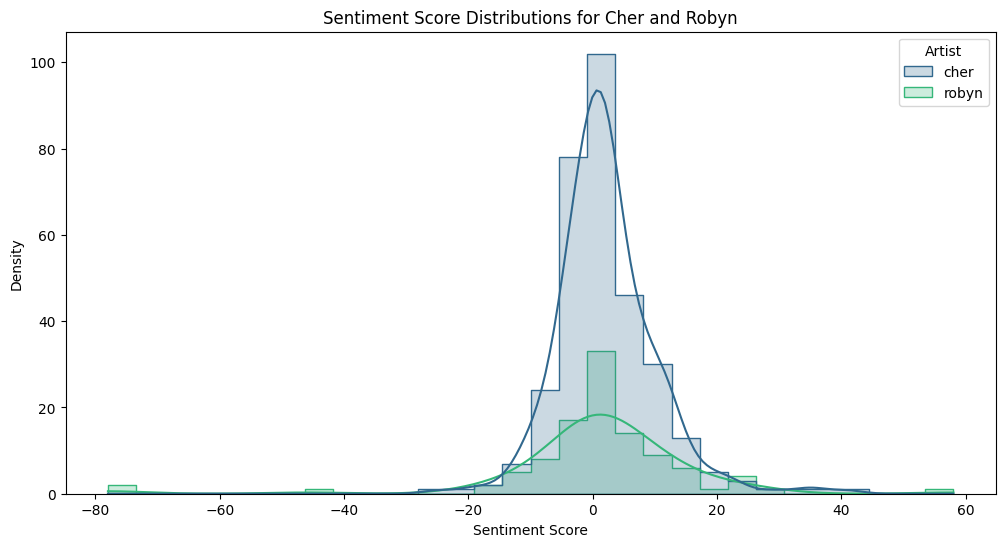

In [37]:
# Convert sentiment scores to a DataFrame for plotting
sentiment_df = pd.DataFrame([
    {'Artist': artist, 'Song': song, 'Sentiment Score': score}
    for artist, songs in sentiment_scores.items()
    for song, score in songs.items()
])

# Plot the sentiment score distributions
plt.figure(figsize=(12, 6))
sns.histplot(data=sentiment_df, x='Sentiment Score', hue='Artist', kde=True, bins=30, palette='viridis', element='step')
plt.title('Sentiment Score Distributions for Cher and Robyn')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.show()

The two artist appear to have a normal distribution ranging from positive to negative sentiment scores. Off initial glance, it appears that the median is slightly more positive, but the difference in density can be attributed to the difference in song releases between the two artist. 

## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/). 

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. You do not need to calculate sentiment on non-emoji content for this section.

In [38]:
# your code here

import os
from collections import defaultdict
import pandas as pd

# Define two sets of emojis as positive and negative
positive_emojis = {
    "😀", "😃", "😄", "😁", "😆", "😊", "😍", "😘", "😇", "👍",
    "😋", "😎", "😜", "😸", "😹", "😻", "😼", "🙌", "👏", "💪",
    "🤗", "💖", "💝", "🌟", "🎉", "✨", "🎈", "😌", "😁", "😆"
}

negative_emojis = {
    "😞", "😡", "😠", "😢", "😭", "😒", "😔", "👎", "💔", "😤",
    "😟", "😕", "😣", "😫", "😩", "😬", "😰", "😱", "😳", "😵",
    "😢", "😦", "😧", "😨", "😩", "😫", "😰", "😿", "🙀", "💢"
}

# Associate positive emojis with +1 and negative emojis with -1
emoji_sentiment_dict = {emoji: 1 for emoji in positive_emojis}
emoji_sentiment_dict.update({emoji: -1 for emoji in negative_emojis})

# Function to calculate emoji sentiment score for a given text
def calculate_emoji_sentiment(text, emoji_sentiment_dict):
    score = sum(emoji_sentiment_dict.get(char, 0) for char in text)
    return score

# Calculate average emoji sentiment scores for each artist
emoji_sentiment_scores = {}
for artist, descriptions in twitter_dict.items():
    total_score = sum(calculate_emoji_sentiment(desc, emoji_sentiment_dict) for desc in descriptions)
    avg_score = total_score / len(descriptions) if descriptions else 0
    emoji_sentiment_scores[artist] = avg_score

# Output the emoji sentiment scores
print("\nEmoji Sentiment Scores for Twitter Descriptions:")
for artist, score in emoji_sentiment_scores.items():
    print(f"Artist: {artist}, Average Emoji Sentiment Score: {score}")

# Example questions and answers
highest_avg_emoji_sentiment_artist = max(emoji_sentiment_scores, key=emoji_sentiment_scores.get)
print(f"\nArtist with the highest average emoji sentiment score: {highest_avg_emoji_sentiment_artist}")



Emoji Sentiment Scores for Twitter Descriptions:
Artist: cher_followers_data, Average Emoji Sentiment Score: 0.028820931184375707
Artist: robynkonichiwa_followers_data, Average Emoji Sentiment Score: 0.017612884863299236
Artist: cher_followers, Average Emoji Sentiment Score: 0.0
Artist: robynkonichiwa_followers, Average Emoji Sentiment Score: 0.0

Artist with the highest average emoji sentiment score: cher_followers_data


Q: What is the average sentiment of your two artists? 

A: When comparing the sentiments for both artists, cher followers express a slightly more positive outlook than those of robyn with a difference of ~0.112. This is calculated by taking the difference in assigned emoji score of cher ~0.288 vs robyn ~0.176. 

---

Q: Which positive emoji is the most popular for each artist? Which negative emoji? 



In [39]:
# Define two sets of emojis as positive and negative
positive_emojis = {
    "😀", "😃", "😄", "😁", "😆", "😊", "😍", "😘", "😇", "👍",
    "😋", "😎", "😜", "😸", "😹", "😻", "😼", "🙌", "👏", "💪",
    "🤗", "💖", "💝", "🌟", "🎉", "✨", "🎈", "😌", "😁", "😆"
}

negative_emojis = {
    "😞", "😡", "😠", "😢", "😭", "😒", "😔", "👎", "💔", "😤",
    "😟", "😕", "😣", "😫", "😩", "😬", "😰", "😱", "😳", "😵",
    "😢", "😦", "😧", "😨", "😩", "😫", "😰", "😿", "🙀", "💢"
}

# Function to count emoji occurrences in text
def count_emojis(text, emoji_set):
    emoji_counter = Counter(char for char in text if char in emoji_set)
    return emoji_counter

# Count emojis for each artist
emoji_counts = {artist: {'positive': Counter(), 'negative': Counter()} for artist in twitter_dict}
for artist, descriptions in twitter_dict.items():
    for desc in descriptions:
        emoji_counts[artist]['positive'].update(count_emojis(desc, positive_emojis))
        emoji_counts[artist]['negative'].update(count_emojis(desc, negative_emojis))

# Determine the most popular positive and negative emojis for each artist
most_popular_positive_emojis = {artist: max(counts['positive'], key=counts['positive'].get, default='None') for artist, counts in emoji_counts.items()}
most_popular_negative_emojis = {artist: max(counts['negative'], key=counts['negative'].get, default='None') for artist, counts in emoji_counts.items()}

# Output the most popular positive and negative emojis
print("\nMost Popular Positive Emojis for Each Artist:")
for artist, emoji in most_popular_positive_emojis.items():
    count = emoji_counts[artist]['positive'][emoji]
    print(f"Artist: {artist}, Emoji: {emoji}, Count: {count}")

print("\nMost Popular Negative Emojis for Each Artist:")
for artist, emoji in most_popular_negative_emojis.items():
    count = emoji_counts[artist]['negative'][emoji]
    print(f"Artist: {artist}, Emoji: {emoji}, Count: {count}")


Most Popular Positive Emojis for Each Artist:
Artist: cher_followers_data, Emoji: ✨, Count: 45846
Artist: robynkonichiwa_followers_data, Emoji: ✨, Count: 3217
Artist: cher_followers, Emoji: None, Count: 0
Artist: robynkonichiwa_followers, Emoji: None, Count: 0

Most Popular Negative Emojis for Each Artist:
Artist: cher_followers_data, Emoji: 💔, Count: 2001
Artist: robynkonichiwa_followers_data, Emoji: 💔, Count: 72
Artist: cher_followers, Emoji: None, Count: 0
Artist: robynkonichiwa_followers, Emoji: None, Count: 0


As we can see in the above output, the most popular positive emoji among both artist was ✨. The frequency did drastically vary at 45846 for cher and 3217 for robyn. Interestingly, the most common negative emoji was the same for both artist 💔. The count also varied drastically at 2001 vs 72. My natural curiousity would be if the twitter followers follow both artists and their demographics (age, sex, etc.)